****Using UNet autoencoder to denoise Brain Tumor MRIs and measure efficacy of these results by using Bayesian Neural Network.**** Brain Tumor MRIs of 4 classifications: glioma, meningioma, pituitary, and no tumor. Applied red noise to these images (to see more about red noise read https://nickraisgit.github.io/paper.pdf). Used UNet autoencoder to clean the noisy images. Built and trained a Bayesian Neural Network to display probability distributions of tumor predictions of noisy images, denoised images, and original images. All of this data that was predicted by the Bayesian Network were part of a holdout set that neither of the models saw during training, in an attempt to simulate real world situations. Comparing results, the denoised images had much less uncertainty in the classification than the noisy images, and were very close to the original images as well. This goes to show how well the UNet denoised these images. 

**Import libraries**

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tqdm import tqdm
import os
from sklearn.utils import shuffle
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import EfficientNetB2,EfficientNetB3,EfficientNetB5,InceptionResNetV2#,EfficientNetV2S
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint
import keras
import sklearn.metrics as metrics
from sklearn.metrics import classification_report
#from pretty_confusion_matrix import pp_matrix
#confusion_matrix = metrics.confusion_matrix(y_true=y_test_labels, y_pred=pred_labels)  # shape=(12, 12)
from sklearn.metrics import confusion_matrix
from albumentations.augmentations.transforms import Blur
from tensorflow.keras.optimizers import RMSprop

2022-12-30 04:32:13.094572: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/cv2/../../lib64:/usr/local/nvidia/lib:/usr/local/nvidia/lib64
2022-12-30 04:32:13.094656: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/cv2/../../lib64:/usr/local/nvidia/lib:/usr/local/nvidia/lib64
2022-12-30 04:32:13.094665: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure t

**Load In/Preprocess Data**

In [2]:
labels=[]

file_dir=''

In [3]:
for sub_folder in os.listdir(os.path.join(file_dir,'Training')):
    labels.append(sub_folder)

In [4]:
print(labels)

['glioma', 'meningioma', 'notumor', 'pituitary']


In [5]:
X_train = []
y_train = []
X_holdout = []
y_holdout = []
new_size = 224

In [6]:
import imageio

In [7]:
f=0
for i in labels:
    train_path = os.path.join(file_dir,'Training',i)
    for j in tqdm(os.listdir(train_path)):
        img = cv2.imread(os.path.join(train_path,j))
        img = cv2.resize(img,(new_size, new_size))
        
        
        X_train.append(img)
        #X_train.append(transf_img)
        #y_train.append(i)
        y_train.append(i)
        
for i in labels:
    test_path = os.path.join(file_dir,'Testing',i)
    for j in tqdm(os.listdir(test_path)):
        img = cv2.imread(os.path.join(test_path,j))
        img = cv2.resize(img,(new_size,new_size))
        
        X_holdout.append(img)
        y_holdout.append(i)


100%|██████████| 300/300 [00:00<00:00, 384.53it/s]


In [8]:
X_train, y_train = shuffle(X_train,y_train, random_state=42)

In [9]:
X_holdout, y_holdout = shuffle(X_holdout, y_holdout, random_state = 42)

In [10]:
X_train,X_test,y_train,y_test = train_test_split(X_train,y_train, test_size=0.2,random_state=42,stratify=y_train)

In [11]:
labelEncoder = LabelEncoder()
labels_train=labelEncoder.fit(y_train)
y_train1=labelEncoder.transform(y_train)
y_holdout = labelEncoder.transform(y_holdout)

In [12]:
y_train = []

In [13]:
for i in (y_train1):
    y_train.append(i)

In [14]:
y_holdout

array([3, 3, 0, ..., 3, 2, 3])

In [15]:
y_train1 = []

In [16]:
len(X_train)

4569

In [17]:
from keras.applications.vgg19 import VGG19
from keras.applications.densenet import DenseNet169
from keras.applications.resnet import ResNet152
from keras.layers import Dense, GlobalAveragePooling2D, Flatten, Dropout
from keras.models import Model
from keras import backend as K
from keras.models import Model
from keras.layers import Input 
import keras

In [18]:
X_holdout = np.array(X_holdout)
y_holdout = np.array(y_holdout)

In [19]:
len(X_train)

4569

**Apply Red Noise**; for more info on the red noise augmentation, can read https://nickraisgit.github.io/paper.pdf

In [20]:
def red_noise(X_train_inside, y_train_inside,blend, new_size = 224 ):
    X_train_in = []
    y_train_in = []
    X_train_in = X_train_inside[:]
    y_train_in = y_train_inside[:]
    X_train_in2 = X_train_inside[:]
    y_train_in2 = y_train_inside[:]
    X_train_in = np.array(X_train_in)
    X_train_in = X_train_in[:,:,:,0]
    for i in tqdm(range(len(X_train_in))):
        whiteNoise = np.random.rand(224,224)
        whiteNoiseFFT = np.fft.fft2(whiteNoise)

        #print(whiteNoiseFFT)
        #plt.imshow(np.abs(whiteNoiseFFT)**0.001)
        u_freqs = np.fft.fftfreq(len(whiteNoise))[:, np.newaxis]
        v_freqs = np.fft.fftfreq(len(whiteNoise))[np.newaxis, :]
        final_freqs = 2*np.pi*(np.sqrt((u_freqs**2)+(v_freqs**2)))
        #plt.imshow(final_freqs)
        #freqs = np.fft.fftfreq(len(whiteNoise))
        weights = ((final_freqs[1,1])**2)/((np.maximum(final_freqs, final_freqs[1,1]))**2)
        weights1 = weights[:,:]
        filtered_fft = weights * whiteNoiseFFT

        inversed_fft = np.fft.ifft2(filtered_fft).real

        control_signal = (inversed_fft-np.quantile(inversed_fft, q = 0.5))
        control_signal = np.maximum(control_signal, 0)
        blending_coeff = blend
        red_noise = (control_signal/control_signal.max())*255
        new_img = X_train_in[i] * (1-blending_coeff) + red_noise*(blending_coeff)
        
        X_train_in2.append(new_img)
        y_train_in2.append(y_train_in[i])
    y_train_in2 = labelEncoder.inverse_transform(y_train_in2)
    
    f=0
    for i in tqdm(range(len(X_train_in2))):
        X_train_inside.append(X_train_in2[i])
        y_train_inside.append(y_train_in2[i])
    return X_train_inside, y_train_inside

In [21]:
X_train, y_train = red_noise(X_train, y_train, blend = 0.5)

100%|██████████| 9138/9138 [00:00<00:00, 1187052.46it/s]


In [22]:
!rm -r LoadedTraining/

rm: cannot remove 'LoadedTraining/': No such file or directory


In [23]:

labelEncoder = LabelEncoder()
labels_train=labelEncoder.fit(y_test)
y_train1=labelEncoder.transform(y_test)


In [24]:

y_test = []

In [25]:
for i in (y_train1):
    y_test.append(i)

In [26]:
y_train1 = []

In [27]:
len(X_train)

13707

In [28]:
X_val, y_val = red_noise(X_test, y_test, blend = 0.5)

100%|██████████| 2286/2286 [00:00<00:00, 1290989.49it/s]


In [29]:
len(X_val)

3429

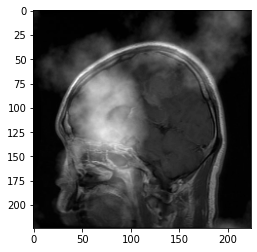

In [30]:
plt.imshow(X_train[9138], cmap = 'gray')

In [31]:
training = []

In [32]:
for i in range(9138,13707):
  training.append(X_train[i])

In [33]:
targets = []

In [34]:
for i in range(4569):
  targets.append(X_train[i])

In [35]:
val_training = []

In [36]:
for i in range(2286,3429):
  val_training.append(X_val[i])

In [37]:
val_targets = []

In [38]:
for i in range(1143):
  val_targets.append(X_val[i])

In [39]:
len(val_targets)

1143

In [40]:
X_holdout2 = []
y_holdout2 = []
for i in range(y_holdout.shape[0]):
  y_holdout2.append(y_holdout[i])
  X_holdout2.append(X_holdout[i])

In [41]:
len(X_holdout)

1311

In [42]:
X_hol, y_hol = red_noise(X_holdout2, y_holdout2, blend = 0.5)

100%|██████████| 2622/2622 [00:00<00:00, 1369888.53it/s]


In [43]:
len(X_hol)

3933

In [44]:
hol_training = []

In [45]:
for i in range(2622,3933):
  hol_training.append(X_hol[i])

In [46]:
hol_targets = []

In [47]:
for i in range(1311):
  hol_targets.append(X_hol[i])

In [48]:
len(val_targets)

1143

In [49]:
training = np.array(training)
targets = np.array(targets)
val_training = np.array(val_training)
val_targets = np.array(val_targets)
hol_training = np.array(hol_training)
hol_targets = np.array(hol_targets)

In [50]:
training.shape

(4569, 224, 224)

In [51]:
targets.shape

(4569, 224, 224, 3)

In [52]:
targets2 = targets[:,:,:,0]

In [53]:
val_targets2 = val_targets[:,:,:,0]

In [54]:
hol_targets2 = hol_targets[:,:,:,0]

In [55]:
training.max()

255.0

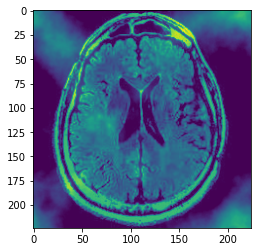

In [56]:
##Example of noisy image (input)
plt.imshow(training[1])

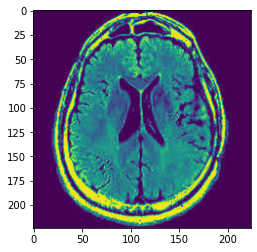

In [145]:
##Example of clean image (target)
plt.imshow(targets2[1])

In [57]:
targets.shape

(4569, 224, 224, 3)

**Create Model**

In [58]:
##Create UNet Autoencoder with latent space of 4
input_data = tf.keras.layers.Input(shape = (224,224,1))
x1 = tf.keras.layers.Conv2D(64, kernel_size = (2,2), padding = 'same', activation = 'relu')(input_data)
x = tf.keras.layers.MaxPool2D((2,2))(x1)
x2 = tf.keras.layers.Conv2D(32, (2,2), padding = 'same', activation = 'relu')(x)
x = tf.keras.layers.MaxPool2D((2,2))(x2)
x3 = tf.keras.layers.Conv2D(16, (2,2), padding = 'same', activation = 'relu')(x)
x = tf.keras.layers.MaxPool2D((2,2))(x3)
shape_before_flatten = tf.keras.backend.int_shape(x)[1:]
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(256, activation = 'relu')(x)
  
latent_space = tf.keras.layers.Dense(4)(x)


  


x = tf.keras.layers.Dense(256, activation = 'relu')(latent_space)
x = tf.keras.layers.Dense(units=np.prod(shape_before_flatten))(x)
x = tf.keras.layers.Reshape(target_shape = shape_before_flatten)(x)
x = tf.keras.layers.UpSampling2D((2,2))(x)
x = tf.keras.layers.Conv2DTranspose(16, (2,2), padding = 'same', activation = 'relu')(x)
x = tf.keras.layers.Concatenate()([x, x3])
x = tf.keras.layers.Conv2D(16, (2,2), padding = 'same', activation = 'relu')(x)
x = tf.keras.layers.UpSampling2D((2,2))(x)
x = tf.keras.layers.Conv2DTranspose(32, (2,2), padding = 'same', activation = 'relu')(x)
x = tf.keras.layers.Concatenate()([x, x2])
x = tf.keras.layers.Conv2D(32, (2,2), padding = 'same', activation = 'relu')(x)
x = tf.keras.layers.UpSampling2D((2,2))(x)
x = tf.keras.layers.Conv2DTranspose(64, (2,2), padding = 'same', activation = 'relu')(x)
x = tf.keras.layers.Concatenate()([x, x1])
x = tf.keras.layers.Conv2D(64, (2,2), padding = 'same', activation = 'relu')(x)
output = tf.keras.layers.Conv2D(1, kernel_size = (2,2), padding = 'same', activation = 'relu')(x)

ae = tf.keras.models.Model(input_data, output)
ae.compile(loss='mse', optimizer='adam')
ae.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 224, 224, 64  320         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 112, 112, 64  0           ['conv2d[0][0]']                 
                                )                                                             

In [59]:
training = np.expand_dims(training, axis = 3)
targets2 = np.expand_dims(targets2, axis = 3)
val_training = np.expand_dims(val_training, axis = 3)
val_targets2 = np.expand_dims(val_targets2, axis = 3)

In [61]:
##Normalize data
targets2 = targets2/255.
training = training/255.
hol_training = hol_training/255.

**Fit Model**

In [ ]:
ae.fit(training, targets2, epochs = 25, batch_size = 32, validation_split=0.2)

In [62]:
hol_targets = np.array(hol_targets)

In [63]:
hol_targets2 = hol_targets2/255.

In [64]:
model_ae = keras.models.load_model('rednoiseunetbest.h5')

In [68]:
hol_targets2 

255

**Assess results on holdout set**

In [70]:
model_ae.evaluate(hol_training, hol_targets2)


41/41 [==============================] - 5s 122ms/step - loss: 0.0024


0.0024334676563739777

Loss of 0.0024 is very good

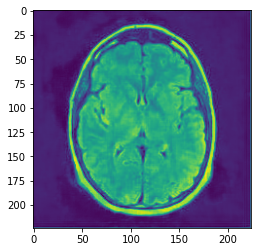

In [75]:
##Generated image from autoencoder, looks really clean
plt.imshow(prediction[5])

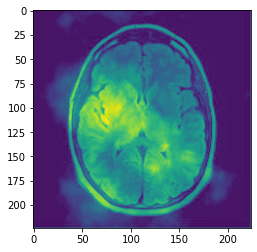

In [76]:
##Same image with red noise
plt.imshow(hol_training[5][:,:,0])

In [63]:
import tensorflow_probability as tfp
tfd = tfp.distributions
tfpl = tfp.layers


In [64]:
print(tf.__version__)

2.11.0


In [65]:
y_train = np.array(y_train)

In [66]:
y_hol = np.array(y_hol)

In [67]:
y_hol.shape


(3933,)

In [68]:
y_hol = y_hol[:1311]

In [69]:
y_hol2 = y_hol[:]

In [70]:
y_hol = tf.keras.utils.to_categorical(y_hol)

In [71]:
targets.shape

(4569, 224, 224, 3)

In [72]:
y_train = y_train[:4569]

In [73]:
y_train2 = y_train[:]

In [74]:
y_train = tf.keras.utils.to_categorical(y_train)

In [75]:
y_train.shape

(4569, 4)

In [76]:
y_hol.shape

(1311, 4)

In [77]:
y_hol = y_hol.astype('uint8')

In [78]:
def analyse_model_prediction(data, true_labels, model, image_num, run_ensemble=False):
    if run_ensemble:
        ensemble_size = 10
    else:
        ensemble_size = 1
    image = data[image_num]
    true_label = true_labels[image_num, 0]
    predicted_probabilities = np.empty(shape=(ensemble_size, 4))
    for i in range(ensemble_size):
        predicted_probabilities[i] = model(image[np.newaxis, :]).mean().numpy()[0]
    model_prediction = model(image[np.newaxis, :])
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10, 2),
                                   gridspec_kw={'width_ratios': [2, 4]})
    
    # Show the image and the true label
    ax1.imshow(image[..., 0], cmap='gray')
    ax1.axis('off')
    ax1.set_title('True label: {}'.format(str(true_label)))
    
    # Show a 95% prediction interval of model predicted probabilities
    pct_2p5 = np.array([np.percentile(predicted_probabilities[:, i], 2.5) for i in range(4)])
    pct_97p5 = np.array([np.percentile(predicted_probabilities[:, i], 97.5) for i in range(4)])    
    bar = ax2.bar(np.arange(4), pct_97p5, color='red')
    bar[int(true_label)].set_color('green')
    ax2.bar(np.arange(4), pct_2p5-0.02, color='white', linewidth=1, edgecolor='white')
    ax2.set_xticks(np.arange(4))
    ax2.set_ylim([0, 1])
    ax2.set_ylabel('Probability')
    ax2.set_title('Model estimated probabilities')
    plt.show()

**Create Bayesian Neural Network**, for more in depth experimentation with this model look at https://github.com/RaviRaisinghani/prob-dl/blob/main/probabilistic_cnn.ipynb

In [79]:
##Make Conv2D reparameterization layer using tf probabilistic layer
def build_convolutional_reparameterization_layer(divergence_func):
    
    con_reparameterization_layer = tfpl.Convolution2DReparameterization(
        filters=8,kernel_size=(5,5),
        activation='relu',padding='VALID',
        kernel_prior_fn=tfpl.default_multivariate_normal_fn,
        kernel_posterior_fn=tfpl.default_mean_field_normal_fn(is_singular=False),
        kernel_divergence_fn=divergence_func,
        bias_prior_fn=tfpl.default_multivariate_normal_fn,
        bias_posterior_fn=tfpl.default_mean_field_normal_fn(is_singular=False),
        bias_divergence_fn=divergence_func)
    
    return con_reparameterization_layer

In [80]:
##Spike and slab method for prior distribution
def spike_and_slab(event_shape, dtype):
    distribution = tfd.Mixture(
        cat=tfd.Categorical(probs=[0.5, 0.5]),
        components=[
            tfd.Independent(tfd.Normal(
                loc=tf.zeros(event_shape, dtype=dtype), 
                scale=1.0*tf.ones(event_shape, dtype=dtype)),
                            reinterpreted_batch_ndims=1),
            tfd.Independent(tfd.Normal(
                loc=tf.zeros(event_shape, dtype=dtype), 
                scale=10.0*tf.ones(event_shape, dtype=dtype)),
                            reinterpreted_batch_ndims=1)],
    name='spike_and_slab')
    return distribution

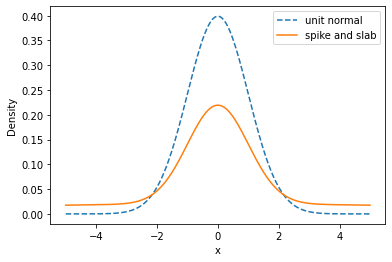

In [81]:
##Plot spike and slab
x_plot = np.linspace(-5, 5, 1000)[:, np.newaxis]
plt.plot(x_plot, tfd.Normal(loc=0, scale=1).prob(x_plot).numpy(), label='unit normal', linestyle='--')
plt.plot(x_plot, spike_and_slab(1, dtype=tf.float32).prob(x_plot).numpy(), label='spike and slab')
plt.xlabel('x')
plt.ylabel('Density')
plt.legend()
plt.show()

In [82]:
##Use spike and slab to retain variational prior
def get_variational_prior(kernel_size, bias_size, dtype=None):

    n = kernel_size+bias_size  
    prior_model = Sequential([tfpl.DistributionLambda(lambda t : spike_and_slab(n, dtype))])
    return prior_model

In [83]:
##Use tf probabilistic layers to retain variational posterior distribution
def get_variational_posterior(kernel_size, bias_size, dtype=None):

    n = kernel_size + bias_size
    return Sequential([
        tfpl.VariableLayer(tfpl.IndependentNormal.params_size(n), dtype=dtype),
        tfpl.IndependentNormal(n)
    ])
    

In [84]:
##Make dense variational layer using prior and posterior functions
def build_dense_variational_layer(prior_fn, posterior_fn, kl_weight):

    return tfpl.DenseVariational(
        units=4, make_posterior_fn=posterior_fn, make_prior_fn=prior_fn, kl_weight=kl_weight
    )

In [85]:
##Build layers
tf.random.set_seed(0)
divergence_func = lambda q, p, _ : tfd.kl_divergence(q, p) / targets.shape[0]


convolutional_reparameterization_layer = build_convolutional_reparameterization_layer(divergence_func=divergence_func
)
dense_variational_layer = build_dense_variational_layer(
    get_variational_prior, get_variational_posterior, kl_weight=1/targets.shape[0]
)

In [86]:
from tensorflow.keras.models import Sequential

**Create Bayesian Neural Network**

In [87]:

def get_bayes(loss, optimizer, metrics):
    inp = tf.keras.layers.Input(shape = (224,224,1))
    x=convolutional_reparameterization_layer(inp)
    x=tf.keras.layers.MaxPooling2D(pool_size=(6, 6))(x)
    x=tf.keras.layers.Flatten()(x)
    x=dense_variational_layer(x)
    #x=tf.keras.layers.Dense(units=tfpl.OneHotCategorical.params_size(4))(x)
    out=tfpl.OneHotCategorical(4, convert_to_tensor_fn=tfd.Distribution.mode)(x)

    bayesian_model = tf.keras.models.Model(inp, out)
    bayesian_model.compile(loss=loss,optimizer=optimizer,metrics=metrics)
    return bayesian_model

In [88]:
targets2.max()

1.0

In [89]:
##negative log likelihood loss
def nll(y_true, y_pred):
   
    return -y_pred.log_prob(y_true)

In [90]:
##custom learning rate seems to work well
bayesian_model = get_bayes(loss=nll,
              optimizer=RMSprop(learning_rate=0.00125),
              metrics=['accuracy'])

/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/tensorflow_probability/python/layers/util.py:95: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  loc = add_variable_fn(
/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/tensorflow_probability/python/layers/util.py:105: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  untransformed_scale = add_variable_fn(


In [91]:
targets2.shape

(4569, 224, 224, 1)

In [92]:
bayesian_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 1)]     0         
                                                                 
 conv2d_reparameterization (  (None, 220, 220, 8)      416       
 Conv2DReparameterization)                                       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 36, 36, 8)        0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 10368)             0         
                                                                 
 dense_variational (DenseVar  (None, 4)                82952     
 iational)                                                       
                                                           

**Fit Bayesian Network**

In [93]:
bayesian_model.fit(targets2, y_train, validation_split = 0.2, epochs = 50)

Epoch 1/50
115/115 [==============================] - 10s 23ms/step - loss: 4.5456 - accuracy: 0.2889 - val_loss: 2.8739 - val_accuracy: 0.2910
Epoch 2/50
115/115 [==============================] - 1s 11ms/step - loss: 2.7398 - accuracy: 0.3037 - val_loss: 2.4737 - val_accuracy: 0.2954
Epoch 3/50
115/115 [==============================] - 1s 11ms/step - loss: 2.4706 - accuracy: 0.3198 - val_loss: 2.4555 - val_accuracy: 0.3392
Epoch 4/50
115/115 [==============================] - 1s 11ms/step - loss: 2.3604 - accuracy: 0.3584 - val_loss: 2.2218 - val_accuracy: 0.3972
Epoch 5/50
115/115 [==============================] - 1s 11ms/step - loss: 2.2639 - accuracy: 0.3789 - val_loss: 2.1259 - val_accuracy: 0.3895
Epoch 6/50
115/115 [==============================] - 1s 11ms/step - loss: 2.1777 - accuracy: 0.4153 - val_loss: 2.0411 - val_accuracy: 0.4486
Epoch 7/50
115/115 [==============================] - 1s 11ms/step - loss: 2.0095 - accuracy: 0.4413 - val_loss: 1.9098 - val_accuracy: 0.496

In [96]:
y_train_ana = np.expand_dims(y_train2, axis = 1)

In [95]:
targets2.shape

(4569, 224, 224, 1)

In [98]:
y_train2.shape

(4569,)

In [127]:
hol_training = np.expand_dims(hol_training, axis = 3)

In [98]:
y_hol.shape

(1311, 4)

In [105]:
y_hol_ana = np.expand_dims(y_hol2, axis =1)

In [109]:
hol_targets = hol_targets[:,:,:,0]

In [114]:
hol_targets = np.expand_dims(hol_targets, axis=3)

In [115]:
hol_targets.shape

(1311, 224, 224, 1)

In [126]:
hol_training.shape

(1311, 224, 224)

**Final Results: Measuring effectiveness of UNet denoising by using probabilistic distributions generated by Bayesian Network.** Distribution shows a much higher level of uncertainty when predicting on noisy data than both clean datasets. Distributions of the denoised images are actually really close to original images, and have much more a

**Noisy Data**

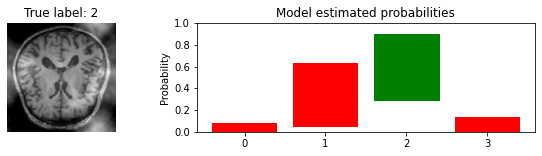

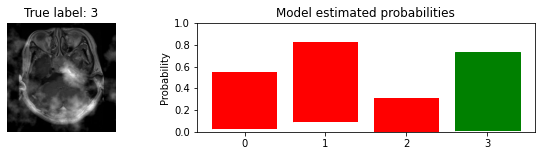

In [135]:
for i in [60, 100]:
    analyse_model_prediction(hol_training, y_hol_ana, bayesian_model, i,run_ensemble=True)

In [101]:
hol_targets = hol_targets[:,:,:,0]

In [103]:
hol_targets = np.expand_dims(hol_targets, axis = 3)

In [124]:
hol_training.shape

(1311, 224, 224)

In [141]:
hol_targets = hol_targets/255.

**Original Clean Images**

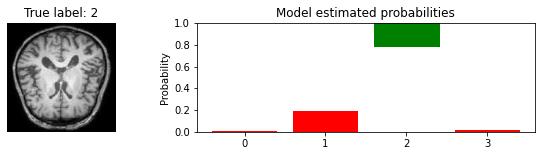

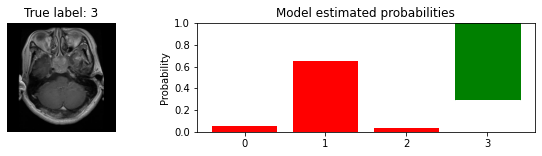

In [143]:
for i in [60, 100]:
    analyse_model_prediction(hol_targets, y_hol_ana, bayesian_model, i,run_ensemble=True)

In [136]:
model_ae = keras.models.load_model('rednoiseunetbest.h5')

In [137]:
predictions = model_ae.predict(hol_training)

41/41 [==============================] - 9s 173ms/step


In [138]:
predictions.shape

(1311, 224, 224, 1)

**Autoencoder denoised data**

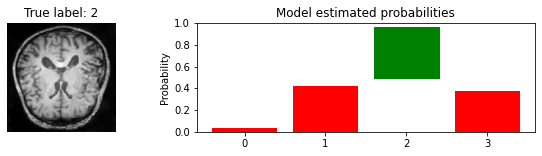

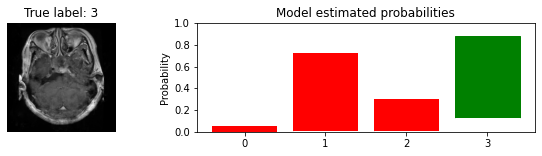

In [148]:
for i in [60, 100]:
    analyse_model_prediction(predictions, y_hol_ana, bayesian_model, i,run_ensemble=True)